In [1]:
#Import all libraries

%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
import random
from scipy.stats import norm

In [2]:
#Function to split dataset into training and validation,
# need to replace with sklearn package

def split(dataset, labelCol):
    
    training = []
    validation = []
    
    dataset = dataset[dataset[:,labelCol].argsort()]
    
    for i in range(len(dataset)):
        
        if i % 10 == 0:
            validation.append(dataset[i])
        
        else:
            training.append(dataset[i])
    
    return np.asarray(training), np.asarray(validation)

In [3]:
#2D Potential paramrters

x1 = 1
y1 = 1

x2 = -0.5
y2 = 0

x3 = 1
y3 = -1.5

x4 = -2
y4 = -2

W = 0.001
sigma = 0.6

factor1 = 1
factor2 = 1
factor3 = 1
factor4 = 1

# Gaussian Function
def gaussian(x, xo):

    g = math.exp(-1 * math.pow((x - xo), 2)/(2 * math.pow(sigma,2)))
    
    return g

#2D Potential Function
def twoDpotential(x,y):
    
    V = W * (math.pow(x,6) + math.pow(y,6)) \
    - factor1 * (gaussian(x, x1) * gaussian(y, y1)) \
    - factor2 * (gaussian(x, x2) * gaussian(y, y2)) \
    - factor3 * (gaussian(x, x3) * gaussian(y, y3)) \
    - factor4 * (gaussian(x, x4) * gaussian(y, y4))
    
    return V

def accX(x,y,vX):
    
    acc = W * (6 * math.pow(x,5)) \
            - factor1 * gaussian(y, y1) * gaussian(x, x1) * (-1 * 2 * (x - x1) / (2 * math.pow(sigma,2))) \
            - factor2 * gaussian(y, y2) * gaussian(x, x2) * (-1 * 2 * (x - x2) / (2 * math.pow(sigma,2))) \
            - factor3 * gaussian(y, y3) * gaussian(x, x3) * (-1 * 2 * (x - x3) / (2 * math.pow(sigma,2))) \
            - factor4 * gaussian(y, y4) * gaussian(x, x4) * (-1 * 2 * (x - x4) / (2 * math.pow(sigma,2))) 
    
    return (-1 * acc)

def accY(x,y,vY):
    
    acc = W * (6 * math.pow(y,5)) \
            - factor1 * gaussian(y, y1) * gaussian(x, x1) * (-1 * 2 * (y - y1) / (2 * math.pow(sigma,2))) \
            - factor2 * gaussian(y, y2) * gaussian(x, x2) * (-1 * 2 * (y - y2) / (2 * math.pow(sigma,2))) \
            - factor3 * gaussian(y, y3) * gaussian(x, x3) * (-1 * 2 * (y - y3) / (2 * math.pow(sigma,2))) \
            - factor4 * gaussian(y, y4) * gaussian(x, x4) * (-1 * 2 * (y - y4) / (2 * math.pow(sigma,2)))
    
    return (-1 * acc)

def run_2D_md(dt, number_of_steps, temp, coord):
    """
    Run a MD simulation.
    
    Parameters
    ----------
    dt: float
        The timestep length (s)
    number_of_steps: int
        Number of iterations in the simulation
    initial_temp: float
        Temperature of the system at 
        initialisation (K)
    x: ndarray of floats
        The initial positions of the particles in a 
        single dimension (Å)
        
    Returns
    -------
    ndarray of floats
        The positions for all of the particles 
        throughout the simulation (Å)
    """
#    positions = np.zeros((number_of_steps, len(x)))
    positionsX = []
    positionsY = []
    positionsX.append(coord[0])
    positionsY.append(coord[1])
    
    x = coord[0]
    y = coord[1]
    
    vX = np.random.uniform(-1 * temp, temp)
    vY = np.random.uniform(-1 * temp, temp)
    aX = accX(x,y,vX)
    aY = accY(x,y,vY)

    for i in range(number_of_steps):
        x = update_pos(x, vX, aX, dt)
        y = update_pos(y, vY, aY, dt)
        a1X = accX(x,y,vX)
        a1Y = accY(x,y,vY)
        vX = update_velo(vX, aX, a1X, dt)
        vY = update_velo(vY, aY, a1Y, dt)
        aX = np.array(a1X)
        aY = np.array(a1Y)
        positionsX.append(x)
        positionsY.append(y)
#        print(x,y,vX,vY,aX,aY,i)
#        positions[i, :] = x
    return positionsX, positionsY

In [4]:
#this is step A
def position_update(x,v,dt):
    x_new = x + v*dt/2.
    return x_new

#this is step B
def velocity_update(v,F,dt):
    v_new = v + F*dt/2.
    return v_new

def random_velocity_update(v,gamma,kBT,dt):
    R = np.random.normal()
    c1 = np.exp(-gamma*dt)
    c2 = np.sqrt(1-c1*c1)*np.sqrt(kBT)
    v_new = c1*v + R*c2
    return v_new

def baoab(potential, max_time, dt, gamma, kBT, initial_position, initial_velocity,
                                        save_frequency=5, **kwargs ):
    x = initial_position[0]
    y = initial_position[1]
    vx = initial_velocity[0]
    vy = initial_velocity[1]

    t = 0
    step_number = 0
    
    positions = []
    velocities = []
    
    total_energies = []
    save_times = []
    
    while(t<max_time):
        
        # B
        potential_energy = potential(x,y,**kwargs)
        forceX = accX(x,y,vx)
        forceY = accY(x,y,vy)
        
        vx = velocity_update(vx,forceX,dt)
        vy = velocity_update(vy,forceY,dt)
        
        #A
        x = position_update(x,vx,dt)
        y = position_update(y,vy,dt)

        #O
        vx = random_velocity_update(vx,gamma,kBT,dt)
        vy = random_velocity_update(vy,gamma,kBT,dt)

        #A
        x = position_update(x,vx,dt)
        y = position_update(y,vy,dt)
        
        # B
        potential_energy = twoDpotential(x,y,**kwargs)
        forceX = accX(x,y,vx)
        forceX = accY(x,y,vy)
        
        vx = velocity_update(vx,forceX,dt)
        vy = velocity_update(vy,forceY,dt)

        if step_number%save_frequency == 0 and step_number>0:
            ke = .5*(vx*vx + vy*vy)
            pe = potential_energy

            positions.append([x,y])
            velocities.append([vx,vy])
            total_energies.append([ke,pe,ke+pe])
            save_times.append(t)
        
        if t % (500) < 0.01:
            print("Currently at t = " + str(t))
        
        t = t+dt
        step_number = step_number + 1
    
    return save_times, positions, velocities, total_energies   

Initial Coordinates = 0, 0
Initial Velocities = 0.3457746504962766, -0.15489178030974998
Initial Kinetic Energy = 0.07177578626667304
Initial Potential energy = -0.7797955186642553
Initial Total energy = -0.7080197323975823
Currently at t = 0
Currently at t = 500.00999999969025
Currently at t = 1000.0099999992356
Currently at t = 1500.0099999987808
Currently at t = 2000.009999998326
Currently at t = 2500.0000000081486
Currently at t = 3000.0000000190626
Currently at t = 3500.0000000299765
Currently at t = 4000.0000000408904
Currently at t = 4500.000000051804
Currently at t = 5000.000000062718
Currently at t = 5500.000000073632
Currently at t = 6000.000000084546
Currently at t = 6500.00000009546
Currently at t = 7000.000000106374
Currently at t = 7500.0000001172875
Currently at t = 8000.0000001282015
Currently at t = 8500.000000139114
Currently at t = 9000.000000150028
Currently at t = 9500.000000160942
Currently at t = 10000.000000171856
Currently at t = 10500.00000018277
Currently at 

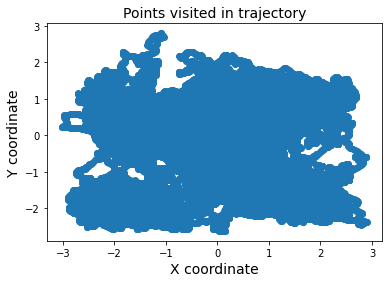

In [5]:
my_max_time = 20000

x = 0
y = 0
vx = np.random.normal(0,0.3)
vy = np.random.normal(0,0.3)

initial_position = [x,y]
initial_velocity = [vx,vy]

my_gamma = 5
my_kBT=(1/9.5)
my_dt=0.01

KE = 0.5 * (vx * vx + vy * vy)
PE = twoDpotential(x,y)

print("Initial Coordinates = " + str(x) + ", " + str(y))
print("Initial Velocities = " + str(vx) + ", " + str(vy))
print("Initial Kinetic Energy = " + str(KE))

print("Initial Potential energy = " + str(PE))

print("Initial Total energy = " + str(PE + KE))


times, positions, velocities, total_energies = baoab(twoDpotential, \
                                                    my_max_time, my_dt, my_gamma, my_kBT, \
                                                    initial_position, initial_velocity,\
                                                    )



times = np.asarray(times)
positions = np.asarray(positions)
velocities = np.asarray(velocities)
total_energies = np.asarray(total_energies)


plt.title('Points visited in trajectory', size=14)
plt.xlabel('X coordinate', size=14)
plt.ylabel('Y coordinate', size=14)
plt.scatter(positions[:,0], positions[:,1])
plt.savefig('toyModel/2Dlangevin4Wells/trajectory.png')

In [6]:
print("Average Kinetic Energy = " + str(total_energies[:,0].mean()))
print("kBT = ", my_kBT)
print("Average Potential Energy = " + str(total_energies[:,1].mean()))
print("Average Total Energy = " + str(total_energies[:,2].mean()))

Average Kinetic Energy = 0.10617552304959837
kBT =  0.10526315789473684
Average Potential Energy = -0.7607754992403911
Average Total Energy = -0.6545999761907927


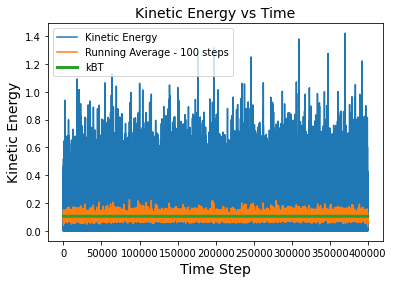

In [7]:
def movingaverage(interval, window_size):
    window= np.ones(int(window_size))/float(window_size)
    return np.convolve(interval, window, 'same')

window_size = 100
ke_av = movingaverage(total_energies[:,0], window_size)

plt.title('Kinetic Energy vs Time', size=14)
plt.plot(total_energies[:,0], label = 'Kinetic Energy')
plt.plot(ke_av, label='Running Average - ' + str(window_size) + ' steps')
plt.plot([my_kBT]*len(total_energies[:,0]), linewidth=3.0, label='kBT')
plt.legend(loc='upper left')
plt.xlabel('Time Step', size=14)
plt.ylabel('Kinetic Energy', size=14)
plt.savefig('toyModel/2Dlangevin4Wells/KE.png')


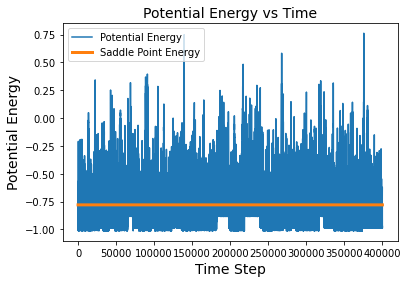

In [8]:
plt.title('Potential Energy vs Time', size=14)
plt.plot(total_energies[:,1], label = 'Potential Energy')
plt.plot([twoDpotential(0,0)]*len(total_energies[:,0]), linewidth=3.0, label='Saddle Point Energy')
plt.legend(loc='upper left')
plt.xlabel('Time Step', size=14)
plt.ylabel('Potential Energy', size=14)
plt.savefig('toyModel/2Dlangevin4Wells/PE.png')


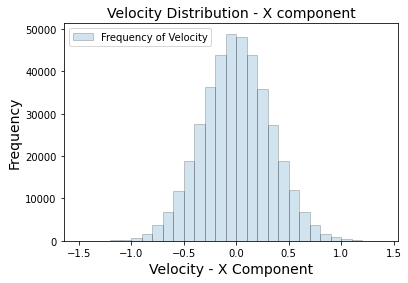

In [9]:
plt.title('Velocity Distribution - X component', size=14)
plt.xlabel('Velocity - X Component', size=14)
plt.ylabel('Frequency', size=14)
bins_list = np.arange(-1.5,1.5,0.1)
plt.hist(velocities[:,0], edgecolor='k', alpha=0.2, bins=bins_list,label='Frequency of Velocity')
plt.legend(loc='upper left')
plt.savefig('toyModel/2Dlangevin4Wells/velocityX.png')

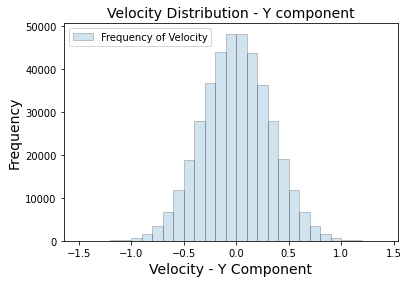

In [10]:
plt.title('Velocity Distribution - Y component', size=14)
plt.xlabel('Velocity - Y Component', size=14)
plt.ylabel('Frequency', size=14)
bins_list = np.arange(-1.5,1.5,0.1)
plt.hist(velocities[:,1], edgecolor='k', alpha=0.2, bins=bins_list,label='Frequency of Velocity')
plt.legend(loc='upper left')
plt.savefig('toyModel/2Dlangevin4Wells/velocityY.png')

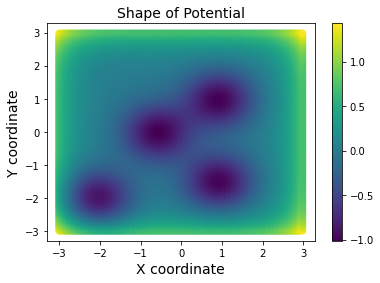

In [11]:
a = np.arange(-3,3,0.02)
b = np.arange(-3,3,0.02)

potential = []

for x in a:
    for y in b:
        
        potential.append([x,y,twoDpotential(x,y)])

potential = np.asarray(potential)

plt.title('Shape of Potential', size=14)
plt.xlabel('X coordinate', size=14)
plt.ylabel('Y coordinate', size=14)
plt.scatter(potential[:,0],potential[:,1],c=potential[:,2])
# plt.tricontour(potential[:,0],potential[:,1],potential[:,2],500)
plt.colorbar()
plt.savefig('toyModel/2Dlangevin4Wells/potential.png')

In [12]:
positionsX = positions[:,0]
positionsY = positions[:,1]
velocitiesX = velocities[:,0]
velocitiesY = velocities[:,1]

min1 = twoDpotential(x1,y1)
min2 = twoDpotential(x2,y2)
min3 = twoDpotential(x3,y3)
min4 = twoDpotential(x4,y4)

width = my_kBT

data = np.vstack((positionsX,positionsY,velocitiesX,velocitiesY)).T

dataset = []
nextState = [-1, -1]

nTransitions = -1
prevState = -1

dist = np.asarray([0,0,0,0]) #Placeholder distance array

for i in range(len(data)):
    
    if i % 9999 == 0:
        print("Finished step: " + str(i+1) + " of " + str(len(data)))
    
    x = data[i][0]
    y = data[i][1]
    velX = data[i][2]
    velY = data[i][3]

    
    if i < nextState[0]:
        dataset.append([x, y, velX, velY, nextState[1]])
        continue
    
    currPotential = twoDpotential(x,y)

    dist[0] = np.sqrt(math.pow(x-x1,2) + math.pow(y-y1,2))
    dist[1] = np.sqrt(math.pow(x-x2,2) + math.pow(y-y2,2))
    dist[2] = np.sqrt(math.pow(x-x3,2) + math.pow(y-y3,2))
    dist[3] = np.sqrt(math.pow(x-x4,2) + math.pow(y-y4,2))
    
    distMin = dist.argmin() + 1
    
    if currPotential - min1 < width and distMin == 1:
        dataset.append([x, y, velX, velY, 1])
        continue
    
    if currPotential - min2 < width and distMin == 2:
        dataset.append([x, y, velX, velY, 2])
        continue

    if currPotential - min3 < width and distMin == 3:
        dataset.append([x, y, velX, velY, 3])
        continue

    if currPotential - min4 < width and distMin == 4:
        dataset.append([x, y, velX, velY, 4])
        continue
    
    distJ = np.asarray([0,0,0,0])
    
    for j in range(i, len(data)):
        
        xj = data[j][0]
        yj = data[j][1]
        
        currPotential = twoDpotential(xj,yj)

        distJ[0] = np.sqrt(math.pow(xj-x1,2) + math.pow(yj-y1,2))
        distJ[1] = np.sqrt(math.pow(xj-x2,2) + math.pow(yj-y2,2))
        distJ[2] = np.sqrt(math.pow(xj-x3,2) + math.pow(yj-y3,2))
        distJ[3] = np.sqrt(math.pow(xj-x4,2) + math.pow(yj-y4,2))
        
        distJMin = distJ.argmin() + 1
        
        if currPotential - min1 < width and distJMin == 1:            
            dataset.append([x, y, velX, velY, 1])
            nextState = [j,1]
            
            break

        if currPotential - min2 < width and distJMin == 2:            
            
            dataset.append([x, y, velX, velY, 2])
            nextState = [j,2]
            break

        if currPotential - min3 < width and distJMin == 3:            
            
            dataset.append([x, y, velX, velY, 3])
            nextState = [j,3]
            break

        if currPotential - min4 < width and distJMin == 4:            
            
            dataset.append([x, y, velX, velY, 4])
            nextState = [j,4]
            break

dataset = np.asarray(dataset)
unique, counts = np.unique(dataset[:,4], return_counts = True)
print(unique, counts)

Finished step: 1 of 400000
Finished step: 10000 of 400000
Finished step: 19999 of 400000
Finished step: 29998 of 400000
Finished step: 39997 of 400000
Finished step: 49996 of 400000
Finished step: 59995 of 400000
Finished step: 69994 of 400000
Finished step: 79993 of 400000
Finished step: 89992 of 400000
Finished step: 99991 of 400000
Finished step: 109990 of 400000
Finished step: 119989 of 400000
Finished step: 129988 of 400000
Finished step: 139987 of 400000
Finished step: 149986 of 400000
Finished step: 159985 of 400000
Finished step: 169984 of 400000
Finished step: 179983 of 400000
Finished step: 189982 of 400000
Finished step: 199981 of 400000
Finished step: 209980 of 400000
Finished step: 219979 of 400000
Finished step: 229978 of 400000
Finished step: 239977 of 400000
Finished step: 249976 of 400000
Finished step: 259975 of 400000
Finished step: 269974 of 400000
Finished step: 279973 of 400000
Finished step: 289972 of 400000
Finished step: 299971 of 400000
Finished step: 309970 o

<ipython-input-13-ddadd779363d>:8: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  a.figure.savefig('toyModel/2Dlangevin4Wells/endState.png')
/home/preetham/.local/lib/python3.8/site-packages/IPython/core/pylabtools.py:132: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


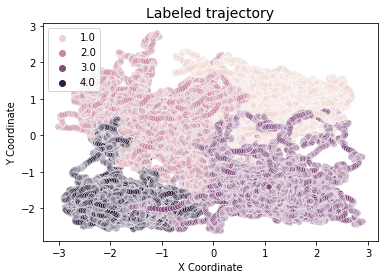

In [13]:
import seaborn as sns

text = 'nTransitions = ' + str(nTransitions)
df = pd.DataFrame(dataset, columns = ['X Coordinate','Y Coordinate','velX','velY','endState'])
a = sns.scatterplot(data=df, x='X Coordinate', y='Y Coordinate', hue='endState')
a.legend(fontsize=10)
a.set_title('Labeled trajectory', size=14)
a.figure.savefig('toyModel/2Dlangevin4Wells/endState.png')

In [14]:
import torch 
import torch.nn.functional as F
from torch import optim
import torch.nn as nn


class Model(nn.Module):
    def __init__(self):
        super().__init__()
        self.hidden = nn.Linear(4, 16)
        self.hidden2 = nn.Linear(16, 8)
        self.activation = nn.ReLU()
        self.output = nn.Linear(8, 4)

    def forward(self, x):
        x = self.hidden(x)
        x = self.activation(x)
        x = self.hidden2(x)
        x = self.activation(x)
        x = self.output(x)
        return x

In [26]:
dataset = np.asarray(dataset)

labelCol = len(dataset[0]) - 1
training, validation = split(dataset, labelCol)

trainInputs = training[:,:labelCol]
trainLabels = training[:,labelCol]
validInputs = validation[:,:labelCol]
validLabels = validation[:,labelCol]

trainInputs = torch.Tensor(trainInputs).cuda()
trainLabels = torch.Tensor(trainLabels).type(torch.LongTensor) - 1
trainLabels = trainLabels.cuda()

validLabels = torch.Tensor(validLabels).type(torch.LongTensor) - 1
validLabels = validLabels.cuda()

In [16]:
model = Model().cuda()
loss_function = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001, betas=(0.9, 0.999), eps=1e-08, weight_decay=0, amsgrad=False)
nEpochs = 5000
losses = np.zeros(nEpochs)

for epoch in range(0, nEpochs): ## run the model for 100 epochs
    
    model.train()
    
    optimizer.zero_grad()
    
    output = model(trainInputs)
    loss = loss_function(output, trainLabels)
    
    loss.backward()
    
    optimizer.step()
    
    losses[epoch] = np.mean(loss.item())
    
    if epoch % 100 == 0:
        print ("Epoch:", epoch, "Training Loss: ", np.mean(loss.item()), ((output.argmax(dim=1) == trainLabels).sum()/len(trainLabels)).item())

Epoch: 0 Training Loss:  1.3775089979171753 0.25025278329849243
Epoch: 100 Training Loss:  1.1553921699523926 0.7469916939735413
Epoch: 200 Training Loss:  0.7420197129249573 0.9127638936042786
Epoch: 300 Training Loss:  0.4943011701107025 0.9420861005783081
Epoch: 400 Training Loss:  0.2057880461215973 0.9491972327232361
Epoch: 500 Training Loss:  0.16466690599918365 0.9497610926628113
Epoch: 600 Training Loss:  0.15258806943893433 0.9502527713775635
Epoch: 700 Training Loss:  0.1448693424463272 0.9506250023841858
Epoch: 800 Training Loss:  0.14132647216320038 0.9507472515106201
Epoch: 900 Training Loss:  0.13954481482505798 0.9509277939796448
Epoch: 1000 Training Loss:  0.13829368352890015 0.9510278105735779
Epoch: 1100 Training Loss:  0.13738493621349335 0.9510861039161682
Epoch: 1200 Training Loss:  0.1367069035768509 0.9511277675628662
Epoch: 1300 Training Loss:  0.136180117726326 0.9511916637420654
Epoch: 1400 Training Loss:  0.1357482373714447 0.9511777758598328
Epoch: 1500 Trai

Validation Loss:  0.1306607723236084 0.9524499773979187


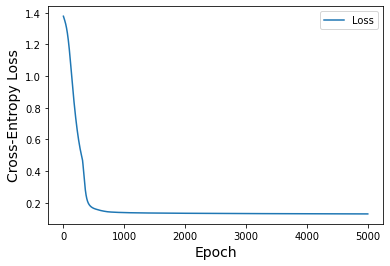

In [28]:
validOutput = model(torch.Tensor(validInputs).cuda())
loss = loss_function(validOutput, validLabels)
print ("Validation Loss: ", np.mean(loss.item()), ((validOutput.argmax(dim=1) == validLabels).sum()/len(validLabels)).item())

###### plt.title('Learning Curve', size=14)
plt.xlabel('Epoch', size=14)
plt.ylabel('Cross-Entropy Loss', size=14)
plt.plot(losses, label='Loss')
plt.legend()
plt.savefig('toyModel/2Dlangevin4Wells/lossCurve.png')


In [20]:
output = model(trainInputs)
output = output.cpu()
trainLabels = trainLabels.cpu()
confusion = np.zeros((4,4))

for i in range(4):
    for j in range(4):
        confusion[i][j] = torch.sum(np.logical_and(output.argmax(dim=1) == j, trainLabels == i))/torch.sum(trainLabels==i)
        
confusion = np.round(confusion,3)
print(confusion)

[[0.953 0.044 0.003 0.   ]
 [0.049 0.934 0.015 0.003]
 [0.01  0.022 0.963 0.005]
 [0.    0.027 0.002 0.971]]


In [16]:
# from sklearn.neural_network import MLPClassifier
# from sklearn import preprocessing
# # from skopt.space import Real, Integer, Categorical 
# # from skopt.utils import use_named_args
# # from skopt import gp_minimize

# dataset = np.asarray(dataset)

# labelCol = len(dataset[0]) - 1
# training, validation = split(dataset, labelCol)

# trainInputs = training[:,:labelCol]
# trainLabels = training[:,labelCol]
# validInputs = validation[:,:labelCol]
# validLabels = validation[:,labelCol]

# scaler = preprocessing.StandardScaler().fit(trainInputs)

# # clf = MLPClassifier(hidden_layer_sizes=[16,8], alpha=0.001,\ Validation accuracy = 0.9
# #                     max_iter = 1000, solver='adam')

# clf = MLPClassifier(hidden_layer_sizes=[16,8],alpha=0.001, \
#                     max_iter = 1000, solver='adam')

# clf.fit(scaler.transform(trainInputs), trainLabels)

# print("Training accuracy =  ", clf.score(scaler.transform(trainInputs), trainLabels))
# print("Validation accuracy = ", clf.score(scaler.transform(validInputs), validLabels))

Training accuracy =   0.9516805555555555
Validation accuracy =  0.95165


In [ ]:
# space=[
#     Categorical(['tanh','relu'],name='activation'),
#     Integer(2,16,name='hiddenLayer1'),
#     Integer(2,16,name='hiddenLayer2'),
#     Integer(2,16,name='hiddenLayer3'),
#     Real(1e-3,1e-1,name='learning_rate_init')
#     ]


In [ ]:
# from sklearn.neural_network import MLPClassifier
# from sklearn import preprocessing
# from skopt.space import Real, Integer, Categorical 
# from skopt.utils import use_named_args
# from skopt import gp_minimize

# space=[
#     Categorical(['tanh','relu'],name='activation'),
#     Integer(2,16,name='hiddenLayer1'),
#     Integer(2,16,name='hiddenLayer2'),
#     Integer(2,16,name='hiddenLayer3'),
#     Real(1e-3,1e-1,name='learning_rate_init')
#     ]

# dataset = np.asarray(dataset)

# labelCol = len(dataset[0]) - 1
# training, validation = split(dataset, labelCol)

# trainInputs = training[:,:labelCol]
# trainLabels = training[:,labelCol]
# validInputs = validation[:,:labelCol]
# validLabels = validation[:,labelCol]

# # scaler = preprocessing.StandardScaler().fit(trainInputs)

# clf = MLPClassifier(max_iter = 1000, solver='adam', random_state=31)


# @use_named_args(space)

# def objective(**params):
    
    
#     params['hidden_layer_sizes']=tuple([params['hiddenLayer1'], \
#                                        params['hiddenLayer2'], \
#                                        params['hiddenLayer3'], \
#                                        ])
    
#     print(params)

#     # the parameters are deleted to avoid an error from the MLPRegressor
#     params.pop('hiddenLayer1')
#     params.pop('hiddenLayer2')
#     params.pop('hiddenLayer3')

#     clf.set_params(**params)
    
#     clf.fit(trainInputs, trainLabels)
    
#     acc = clf.score(validInputs, validLabels)
#     print("Accuracy = ", acc)

#     return (1 - acc)


# clf_gp = gp_minimize(objective, space, n_calls=50, random_state=0)

# # print(scaler.transform(trainInputs).mean())
# print("Optimal params = " + str(clf_gp.x))
# print("Validation Accuracy = ", 1 - clf_gp.fun)

In [ ]:
# committor = []

# trials = 250

# xarray = np.repeat(dataset[:,0], repeats=trials, axis=0)
# yarray = np.repeat(dataset[:,1], repeats=trials, axis=0)

# meanX,stdX=norm.fit(velocities[:,0])
# meanY,stdY=norm.fit(velocities[:,1])

# velX = np.random.normal(meanY, stdY, len(xarray))
# velY = np.random.normal(meanY, stdY, len(yarray))

# print("Started predictions")

# toPred = np.vstack((xarray,yarray,velX,velY)).T
# toPred = scaler.transform(toPred)
# preds = clf.predict(toPred)    

# print("Finished predictions")

# for i in range(0, len(dataset[:,0])):
    
#     predictions = preds[i*trials:(i+1)*trials]
#     unique, count = np.unique(predictions, return_counts=True)
#     if len(unique) == 1:        
#         if unique == 0:
#             counts = [count[0], 0]

#         else:
#             counts = [0, count[0]]
#     else:

#         counts = count

#     counts = np.asarray(counts)/trials
#     committor.append([dataset[i][0],dataset[i][1],counts[1]])

#     if i % 9999 == 0:
#         print("Finished step " + str(i+1) + " of " + str(len(dataset)))

# committor = np.asarray(committor)

# # plt.title('Learned Committor Probability', size = 14)
# # plt.xlabel('Position x', size=14)
# # plt.ylabel('Learned Committor Probability', size=12)


# #plt.tricontour(committor[:,0], committor[:,1], committor[:2])
# # plt.savefig('toyModel/learnedComm.png')    

In [30]:
trials = 500
batch_size = 10000

meanX,stdX=norm.fit(velocities[:,0])
meanY,stdY=norm.fit(velocities[:,1])

print("Started predictions")

committor = np.zeros((1,4))

for i in range(0,len(dataset[:,0])+1,batch_size):
    
    committorTemp = np.zeros((batch_size,4))

    xarray = np.repeat(dataset[i:i+batch_size,0], repeats=trials, axis=0)
    yarray = np.repeat(dataset[i:i+batch_size,1], repeats=trials, axis=0)
    
    
    velX = np.random.normal(meanX, stdX, len(xarray))
    velY = np.random.normal(meanY, stdY, len(yarray))

    toPred = np.vstack((xarray,yarray,velX,velY)).T
    preds = model(torch.Tensor(toPred).cuda())
    preds = preds.argmax(dim=1)
    preds = np.asarray(preds.cpu().detach().numpy())
    
    #Adding to avoid 0 error when len(dataset) divisible by batch_size
    if len(toPred) == 0: 
        break  

    for j in range(0, batch_size):
        
        if i+j >= len(dataset):
            committorTemp = committorTemp[:j]
            break
        predictions = preds[j*trials:(j+1)*trials]
        unique, count = np.unique(predictions, return_counts=True)

        counts = [0, 0, 0, 0]
        
        if len(unique) == 1:
            counts[int(unique) - 1] = count[0]            
        
        if len(unique) == 2:
            counts[int(unique[0]) - 1] = count[0]
            counts[int(unique[1]) - 1] = count[1]
        
        if len(unique) == 3:
            counts[int(unique[0]) - 1] = count[0]
            counts[int(unique[1]) - 1] = count[1]
            counts[int(unique[2]) - 1] = count[2]

        counts = np.asarray(counts)/trials
        committorTemp[j] = counts
        
        
        if int(i+j+1) % 10000 == 0:
            print("Finished step " + str(i+j+1) + " of " + str(len(dataset)))
    
    committor = np.vstack((committor,committorTemp))
    print(committor.shape)
    
committor = committor[1:]

Started predictions
Finished step 10000 of 400000
(10001, 4)
Finished step 20000 of 400000
(20001, 4)
Finished step 30000 of 400000
(30001, 4)
Finished step 40000 of 400000
(40001, 4)
Finished step 50000 of 400000
(50001, 4)
Finished step 60000 of 400000
(60001, 4)
Finished step 70000 of 400000
(70001, 4)
Finished step 80000 of 400000
(80001, 4)
Finished step 90000 of 400000
(90001, 4)
Finished step 100000 of 400000
(100001, 4)
Finished step 110000 of 400000
(110001, 4)
Finished step 120000 of 400000
(120001, 4)
Finished step 130000 of 400000
(130001, 4)
Finished step 140000 of 400000
(140001, 4)
Finished step 150000 of 400000
(150001, 4)
Finished step 160000 of 400000
(160001, 4)
Finished step 170000 of 400000
(170001, 4)
Finished step 180000 of 400000
(180001, 4)
Finished step 190000 of 400000
(190001, 4)
Finished step 200000 of 400000
(200001, 4)
Finished step 210000 of 400000
(210001, 4)
Finished step 220000 of 400000
(220001, 4)
Finished step 230000 of 400000
(230001, 4)
Finished 

RuntimeError: cannot perform reduction function argmax on a tensor with no elements because the operation does not have an identity

In [31]:
committor = committor[1:]

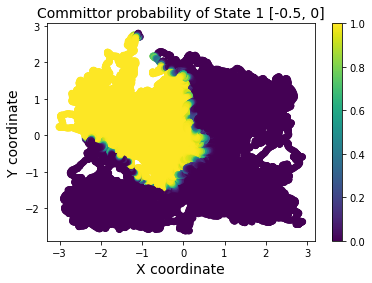

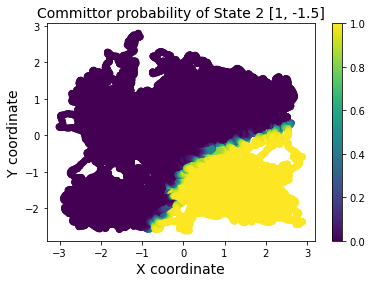

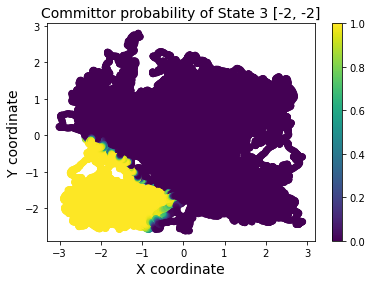

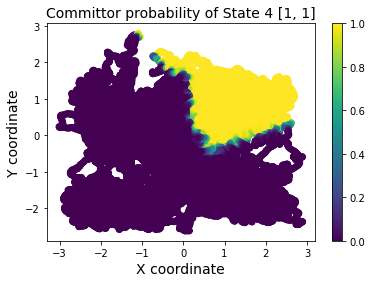

In [32]:
import matplotlib.tri as tri


posDict = {4: [x1,y1], 1:[x2,y2],\
          2: [x3,y3], 3:[x4,y4]}

x = dataset[:,0]
y = dataset[:,1]

for i in range(1,5):
    
    z = committor[:,i-1]
    plt.figure()
    plt.title("Committor probability of State " + str(i) + " " + str(posDict[i]), size=14)
    plt.xlabel('X coordinate', size=14)
    plt.ylabel('Y coordinate', size=14)
    plt.scatter(x,y,c=z)
    plt.colorbar()
    plt.savefig("toyModel/2Dlangevin4Wells/MLP_CommProb_State" + str(i) + ".png")

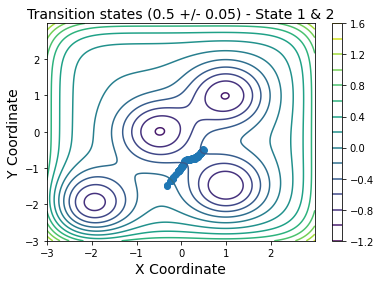

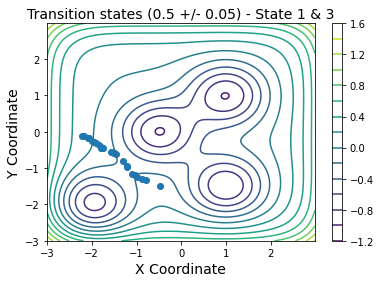

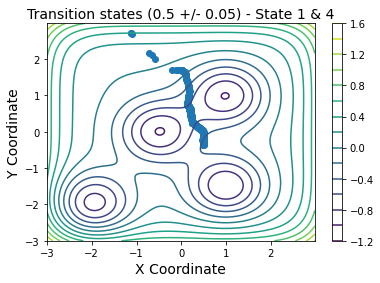

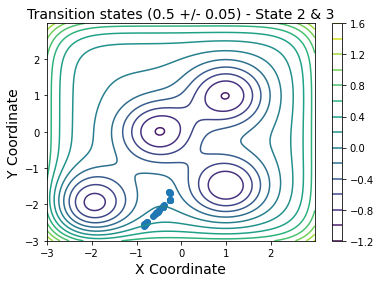

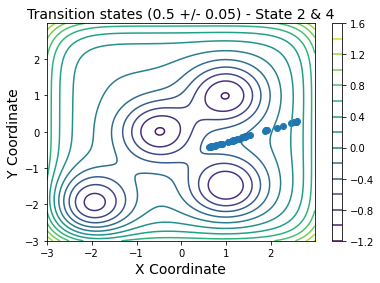

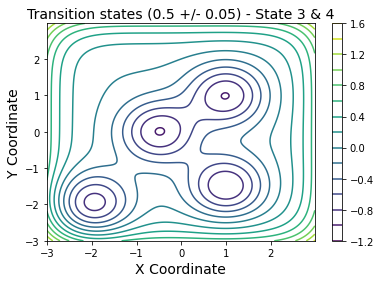

In [35]:
deviation = 0.05

for i in range(1,5):
    for j in range(i+1,5):
        inds = np.where(np.logical_and(np.absolute(committor[:,i-1] -  0.5) < deviation, \
                                 np.absolute(committor[:,j-1] -  0.5) < deviation))

        transitionPts = committor[inds]

        transitionPts = np.asarray(transitionPts)
        plt.figure()
        plt.title("Transition states (0.5 +/- " + str(deviation) + ") - State " + str(i) \
                  + " & " + str(j), size=14)
        plt.xlabel("X Coordinate", size=14)
        plt.ylabel("Y Coordinate", size=14)
        plt.scatter(dataset[inds,0],dataset[inds,1])
        plt.tricontour(potential[:,0],potential[:,1],potential[:,2],15)
        plt.colorbar()
        plt.savefig("toyModel/2Dlangevin4Wells/MLP_TS_State" + str(i) + "_" + str(j) + ".png")

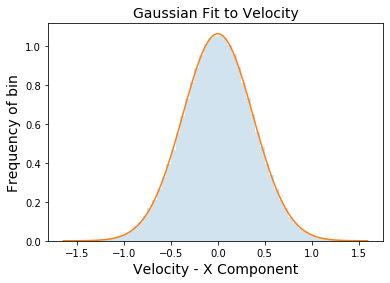

<Figure size 432x288 with 0 Axes>

In [89]:
bins_list = np.arange(-1.5,1.5,0.05)

plt.hist(velocities[:,0], density=True, bins=bins_list, histtype='stepfilled', alpha=0.2)

xmin, xmax = plt.xlim()
x = np.linspace(xmin, xmax, 100)
y = norm.pdf(x, meanX, stdX)

plt.title("Gaussian Fit to Velocity", size=14)
plt.xlabel("Velocity - X Component", size=14)
plt.ylabel("Frequency of bin", size=14)
plt.plot(x, y)
plt.show()
plt.savefig("toyModel/2Dlangevin4Wells/gaussianFit.png")

In [ ]:
print(twoDpotential(1.5,-2))

In [60]:
print(committor[committor[:,2].argmax()])

[ 0.02576325 -0.16544206  0.998     ]


In [12]:
midX = (x1+x2)/2
midY = (y1+y2)/2

print((twoDpotential(x1,y1) - twoDpotential(midX,midY))/my_kBT)
print((twoDpotential(x2,y2) - twoDpotential(midX,midY))/my_kBT)

-3.42301232323141
-3.4602031998936367
